In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Introducción al *Poker Hand Dataset*

El **Poker Hand Dataset** es un conjunto de datos publicado en 2007 por Robert Cattral y Franz Oppacher (Carleton University, Canadá). Su finalidad es representar manos de póker de cinco cartas y clasificarlas automáticamente según la jugada que contienen.

Cada instancia del dataset corresponde a una mano formada por cinco cartas extraídas de una baraja estándar de 52. Cada carta se describe mediante dos atributos: **palo** (1 = Corazones, 2 = Picas, 3 = Diamantes, 4 = Tréboles) y **valor** (1–13). En total, el dataset dispone de **10 atributos predictivos** y una **columna objetivo**, denominada `CLASS`, que identifica el tipo de mano (de 0 a 9), desde “nada” hasta “escalera real”.

Este conjunto ha sido utilizado en investigación como referencia para algoritmos de clasificación, ya que presenta varios retos interesantes:

- Las clases están **muy desbalanceadas** (las manos raras son muy poco frecuentes).
- Determinadas clases han sido **sobre-representadas** en el entrenamiento (como la escalera real y la escalera de color).
- Es un problema que requiere identificar **patrones estructurales** en las cartas, lo que favorece algunos modelos más avanzados.
- No contiene valores nulos, pero sí un dominio amplio de combinaciones posibles.

El dataset está compuesto por:
- **25.010 instancias de entrenamiento**
- **1.000.000 instancias de prueba**
- **11 columnas en total** (10 atributos + 1 clase objetivo)

La variable `CLASS` puede tomar los siguientes valores:

| Clase | Jugada             |
|-------|--------------------|
| 0     | Nada               |
| 1     | Pareja             |
| 2     | Doble pareja       |
| 3     | Trío               |
| 4     | Escalera           |
| 5     | Color              |
| 6     | Full House         |
| 7     | Póker              |
| 8     | Escalera de color  |
| 9     | Escalera real      |


# Cargamos nuestros datos


In [3]:
train_path = "poker-hand-training-true.data"
test_path = "poker-hand-testing.data"

df_train = pd.read_csv(train_path, header=None)
df_test = pd.read_csv(test_path, header=None)

# Renombramos columnas

In [4]:
column_names = ['S1','C1','S2','C2','S3','C3','S4','C4','S5','C5','hand']


In [5]:
df_train.columns = column_names
df_test.columns = column_names


# Exploramos el dataset

In [6]:
df_train.head()



,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,hand
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9


In [7]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25010 entries, 0 to 25009
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   S1      25010 non-null  int64
 1   C1      25010 non-null  int64
 2   S2      25010 non-null  int64
 3   C2      25010 non-null  int64
 4   S3      25010 non-null  int64
 5   C3      25010 non-null  int64
 6   S4      25010 non-null  int64
 7   C4      25010 non-null  int64
 8   S5      25010 non-null  int64
 9   C5      25010 non-null  int64
 10  hand    25010 non-null  int64
dtypes: int64(11)
memory usage: 2.1 MB


In [8]:
df_train.shape

(25010, 11)

In [9]:
df_train.drop_duplicates(inplace=True)

In [10]:
distribucion = df_train['hand'].value_counts(normalize=True).sort_index() * 100
distribucion


hand
0    49.956014
1    42.374440
2     4.822457
3     2.051344
4     0.371881
5     0.215931
6     0.143954
7     0.023992
8     0.019994
9     0.019994
Name: proportion, dtype: float64

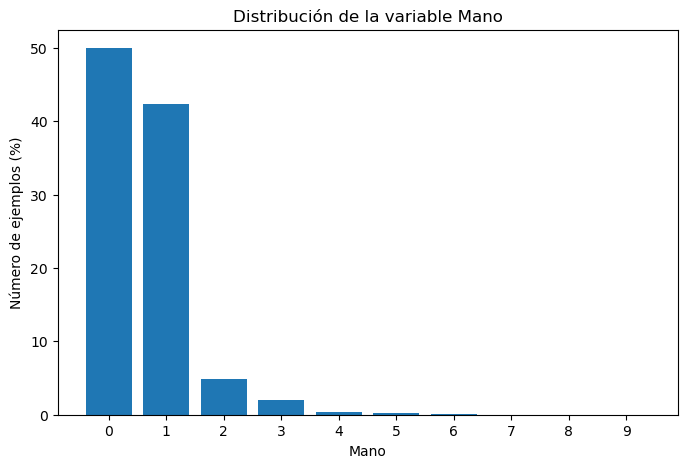

In [11]:
plt.figure(figsize=(8,5))
plt.bar(distribucion.index.astype(str), distribucion.values)
plt.xlabel("Mano")
plt.ylabel("Número de ejemplos (%)")
plt.title("Distribución de la variable Mano")
plt.show()

Esta distribución nos supone un problema, ya que casi el 90% son High Card (La carta más alta, osea la peor mano de todas) o pareja.

De momento vamos a separar features (X) y target (y)

In [12]:
feature_cols = [col for col in df_train.columns if col != "hand"]

X = df_train.drop("hand", axis=1)
y = df_train["hand"]

X.head()


,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5
0,1,10,1,11,1,13,1,12,1,1
1,2,11,2,13,2,10,2,12,2,1
2,3,12,3,11,3,13,3,10,3,1
3,4,10,4,11,4,1,4,13,4,12
4,4,1,4,13,4,12,4,11,4,10


## Respecto a la distribución, qué puedo hacer?
- Over Sampling: me crearía muchos datos y posibles combinaciones "no reales"
- Under Sampling: Perdería casi el 90% de los datos
- 

## TRAIN-TEST SPLIT

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## ESCALADO

In [14]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

## APLICACIÓN DE MODELOS

### KNN:

In [15]:
knn = KNeighborsClassifier()
knn.fit(X_train_norm, y_train)

pred = knn.predict(X_test_norm)
score_knn = knn.score(X_test_norm, y_test)
score_knn


0.508796481407437

In [22]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.55      0.65      0.59      2499
           1       0.46      0.43      0.45      2119
           2       0.04      0.00      0.01       241
           3       0.00      0.00      0.00       103
           4       0.00      0.00      0.00        19
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1

    accuracy                           0.51      5002
   macro avg       0.10      0.11      0.10      5002
weighted avg       0.47      0.51      0.49      5002



c:\Users\andre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### ÁRBOL DE DECISIÓN:

In [16]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt.score(X_test, y_test)


0.48260695721711316

In [18]:
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

### RANDOM FOREST


In [20]:
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",#Es la única forma que encuentro de hacer que 
                            #las clases más raras tengan más peso sin eliminar ni inventarme datos.
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Score en test:", rf.score(X_test, y_test))

Score en test: 0.6039584166333467


In [21]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.62      0.80      0.70      2499
           1       0.57      0.48      0.52      2119
           2       0.00      0.00      0.00       241
           3       0.00      0.00      0.00       103
           4       0.00      0.00      0.00        19
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1

    accuracy                           0.60      5002
   macro avg       0.12      0.13      0.12      5002
weighted avg       0.55      0.60      0.57      5002



c:\Users\andre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### GRID SEARCH

In [ ]:
params = {
    'n_estimators':[100,200],
    'max_depth':[None,10,20],
    'min_samples_split':[2,5]
}

grid = GridSearchCV(RandomForestClassifier(), params, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

grid.best_estimator_
grid.best_score_


np.float64(0.5958710791954669)

In [ ]:
import joblib
joblib.dump(rf, "best_poker_model.pkl")


['best_poker_model.pkl']

In [ ]:
model = joblib.load("best_poker_model.pkl")

pred_new = model.predict(df_test.drop("hand", axis=1))



In [ ]:
pred_new

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(df_test["hand"], pred_new))

              precision    recall  f1-score   support

           0       0.62      0.81      0.70    501209
           1       0.56      0.46      0.50    422498
           2       0.40      0.00      0.00     47622
           3       0.50      0.00      0.00     21121
           4       0.32      0.00      0.00      3885
           5       1.00      0.02      0.04      1996
           6       0.00      0.00      0.00      1424
           7       0.00      0.00      0.00       230
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00         3

    accuracy                           0.60   1000000
   macro avg       0.34      0.13      0.13   1000000
weighted avg       0.58      0.60      0.56   1000000



c:\Users\andre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andre\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
